# Correlation and Cluster analysis of education accross the world.
## Exploration of the bivariate correlation between education-related indexes and all other numerical data of the CIA World Factbook.

Pearson's and Spearman's correlation coefficients are used to explore education. The paper can be found https://www.researchgate.net/publication/344516860_Education_and_International_Relations_A_Data_Analysis_Project and the CIA World Factbook data used can be found at https://github.com/Podipan/cia_world_factbook. The paper-version was based on the 2018 edition of the CIA WFB. The implementation below makes use of the 2019 CIA WFB, hence slight variations of outcomes compared to the original paper.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import MeanShift, KMeans
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
plt.rcParams['figure.dpi'] = 100
desired_width=320
pd.set_option('display.width', desired_width)

import warnings 
warnings.filterwarnings("ignore") #suppresses warnings, not adviced, in this case warnings have been studied carefully and/or refer to the new dataset not used in original paper.

In [2]:
pd.set_option('display.max_columns',10)
edu_cols = ["num people_and_society education_expenditures",
      "num people_and_society school_life_expectancy_primary_to_tertiary_education male",
      "num people_and_society school_life_expectancy_primary_to_tertiary_education female",
      "num people_and_society school_life_expectancy_primary_to_tertiary_education total"]

In [3]:
def get_best_distribution(data):
  import scipy.stats as st
  dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
  dist_results = []
  params = {}
  for dist_name in dist_names:
    dist = getattr(st, dist_name)
    param = dist.fit(data)

    params[dist_name] = param
    # Applying the Kolmogorov-Smirnov test
    D, p = st.kstest(data, dist_name, args=param)
    #print("p value for "+dist_name+" = "+str(p))
    dist_results.append((dist_name, p))

  # select the best fitted distribution
  best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
  # store the name of the best fit and its p value

  #print("Best fitting distribution: "+str(best_dist))
  #print("Best p value: "+ str(best_p))
  #print("Parameters for the best fit: "+ str(params[best_dist]))

  return best_dist, best_p, #params[best_dist]

# temp = data.dropna(axis="rows", how="any")
# for c in data.columns:
#   x = temp[c].values.tolist()
#   best, p = get_best_distribution(x)
#   print(best, p, c)

In [4]:
def Combine_pisa_un_dfs():
  edu_cols = ["num people_and_society education_expenditures",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education male",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education female",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education total"]
  
  pisa = pd.read_excel("pisa.xlsx", index=0)
  data = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")
  edu = pd.read_excel("edu.xlsx", index=0)
  for ind in data.index:
    for i in pisa.index:
      if pisa.loc[i, "Country"].lower() in data.loc[ind, "txt country name"]:
        data.loc[ind, "pisa"] = float(pisa.loc[i, "Score"])
        break
  for ind in data.index:
    for inde in edu.index:
      if edu.loc[inde, "Country"].lower().strip() in data.loc[ind, "txt country name"]:
        data.loc[ind, "edu"] = float(edu.loc[inde, "Score"])
        break
  new = data[["txt country name", "edu", "pisa"]]
  new[edu_cols] = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")[edu_cols]
  new.to_pickle("pisa_un_cia.pkl")
  new.to_excel("pisa_un_cia.xlsx")
Combine_pisa_un_dfs()

In [5]:
def Create_Correlations():
  data = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")
  edu_cols = ["num people_and_society education_expenditures",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education male",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education female",
        "num people_and_society school_life_expectancy_primary_to_tertiary_education total"]
  cors = pd.DataFrame(index=edu_cols)

  for c in edu_cols:
    for col in data.columns:
      if ("education" and "txt ") not in col:
        temp = data[[c,col]].copy()
        temp.dropna(axis="rows", how="any", inplace=True)
        y = temp[c].values
        x = temp[col].values
        x = np.array(x, dtype=np.float)
        x = x.flatten()
        y = np.array(y, dtype=np.float)
        y = y.flatten()
        if len(x) > 2:
          pearson = pearsonr(x, y)
          spearman = spearmanr(x, y)
          cell = ""
          if pearson[1] < 0.05 and spearman[1] < 0.05 and (abs(pearson[0]) > 0.5 or abs(spearman[0]) > 0.5):
            cell = str(round(pearson[0], 4)) + " | " + str(round(spearman[0], 4))
          else:
            cell = np.nan

          cors.loc[c.split("people_and_society ")[-1], col] = cell
  cors.dropna(axis="rows", how="all", inplace=True)
  cors.dropna(axis="columns", how="all", inplace=True)
  cors.to_excel("Correlations2.xlsx")
Create_Correlations()

(69, 2)
SpearmanrResult(correlation=0.5805479780340477, pvalue=1.705039798313698e-07)
(0.5043773690183057, 9.924130680424176e-06)
KendalltauResult(correlation=0.4508102116431055, pvalue=2.5514865786134204e-07)


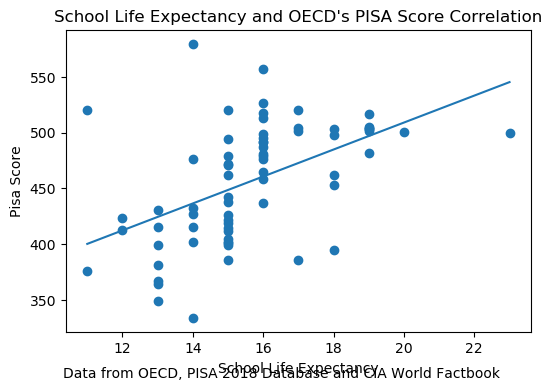

(149, 2)
SpearmanrResult(correlation=0.8945704117393769, pvalue=2.818307724399234e-53) (0.8927556125555118, 9.226797128873062e-53) KendalltauResult(correlation=0.7466452121585142, pvalue=2.3938612909411094e-38)


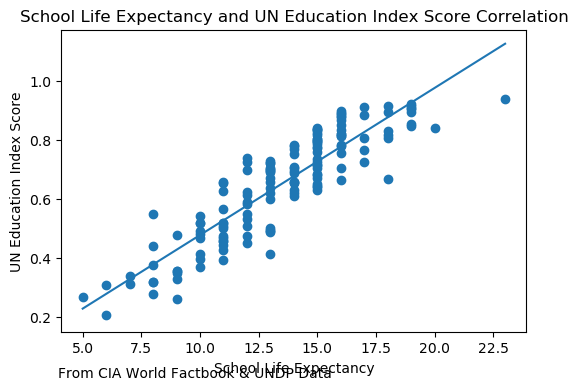

In [6]:
def School_life_Expectancy():
  pisa = pd.read_excel("pisa.xlsx", index=0)
  data = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")
  edu = pd.read_excel("edu.xlsx", index=0)
  for ind in data.index:
    for i in pisa.index:
      if pisa.loc[i, "Country"].lower() in data.loc[ind, "txt country name"]:
        data.loc[ind, "pisa"] = float(pisa.loc[i, "Score"])
        break
  for ind in data.index:
    for inde in edu.index:
      if edu.loc[inde, "Country"].lower().strip() in data.loc[ind, "txt country name"]:
        data.loc[ind, "edu"] = float(edu.loc[inde, "Score"])
        break


  temp = data[["num people_and_society school_life_expectancy_primary_to_tertiary_education total", "pisa"]]
  temp.dropna(axis="rows", how="any", inplace=True)
  print(temp.shape)
  x = temp["num people_and_society school_life_expectancy_primary_to_tertiary_education total"].values
  y = temp["pisa"].values
  print(spearmanr(x, y), pearsonr(x, y), kendalltau(x, y), sep="\n")
  plt.scatter(x,y)
  plt.title("School Life Expectancy and OECD's PISA Score Correlation")
  plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

  plt.xlabel("School Life Expectancy")
  plt.ylabel("Pisa Score")
  plt.gcf().text(0.12, 0.01, "Data from OECD, PISA 2018 Database and CIA World Factbook", fontsize=10)
  plt.show()

  temp = data[["num people_and_society school_life_expectancy_primary_to_tertiary_education total", "edu"]]
  temp.dropna(axis="rows", how="any", inplace=True)
  print(temp.shape)
  x = temp["num people_and_society school_life_expectancy_primary_to_tertiary_education total"].values
  y = temp["edu"].values
  print(spearmanr(x, y), pearsonr(x, y), kendalltau(x, y))
  plt.scatter(x,y)
  plt.title("School Life Expectancy and UN Education Index Score Correlation")
  plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
  plt.xlabel("School Life Expectancy")
  plt.ylabel("UN Education Index Score")
  plt.gcf().text(0.12, 0.01, "From CIA World Factbook & UNDP Data", fontsize=10)
  plt.show()
School_life_Expectancy()

(61, 2)
SpearmanrResult(correlation=0.339063026081969, pvalue=0.007516105073377017)
(0.34971866443421856, 0.005732428773434065)
KendalltauResult(correlation=0.24863396364906076, pvalue=0.005055723283802434)


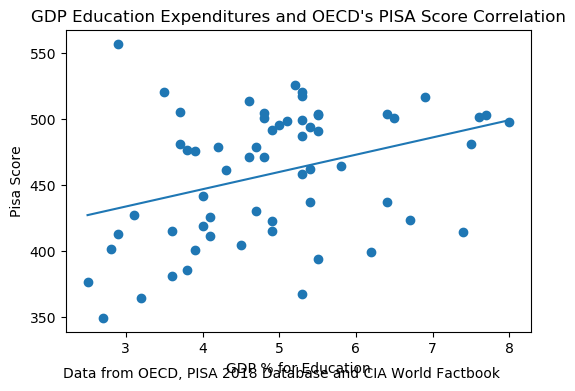

(154, 2)
SpearmanrResult(correlation=0.35861351459891555, pvalue=4.951015295707475e-06)
(0.3102265555926352, 9.021897645989281e-05)
KendalltauResult(correlation=0.24727658742314282, pvalue=6.46357164847219e-06)


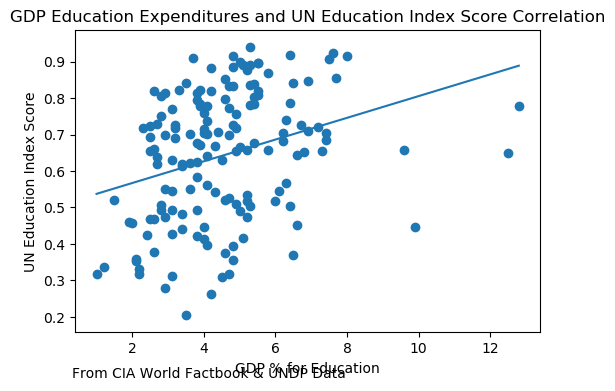

In [7]:
def Education_Expenditures():
  pisa = pd.read_excel("pisa.xlsx", index=0)
  data = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")
  edu = pd.read_excel("edu.xlsx", index=0)
  for ind in data.index:
    for i in pisa.index:
      if pisa.loc[i, "Country"].lower() in data.loc[ind, "txt country name"]:
        data.loc[ind, "pisa"] = float(pisa.loc[i, "Score"])
        break
  for ind in data.index:
    for inde in edu.index:
      if edu.loc[inde, "Country"].lower().strip() in data.loc[ind, "txt country name"]:
        data.loc[ind, "edu"] = float(edu.loc[inde, "Score"])
        break


  temp = data[["num people_and_society education_expenditures", "pisa"]]
  temp.dropna(axis="rows", how="any", inplace=True)
  print(temp.shape)
  x = temp["num people_and_society education_expenditures"].values
  y = temp["pisa"].values
  print(spearmanr(x, y), pearsonr(x, y), kendalltau(x, y), sep="\n")
  plt.scatter(x,y)
  plt.title("GDP Education Expenditures and OECD's PISA Score Correlation")
  plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

  plt.xlabel("GDP % for Education")
  plt.ylabel("Pisa Score")
  plt.gcf().text(0.12, 0.01, "Data from OECD, PISA 2018 Database and CIA World Factbook", fontsize=10)
  plt.show()

  temp = data[["num people_and_society education_expenditures", "edu"]]
  temp.dropna(axis="rows", how="any", inplace=True)
  print(temp.shape)
  x = temp["num people_and_society education_expenditures"].values
  y = temp["edu"].values
  print(spearmanr(x, y), pearsonr(x, y), kendalltau(x, y), sep="\n")
  plt.scatter(x,y)
  plt.title("GDP Education Expenditures and UN Education Index Score Correlation")
  plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
  plt.xlabel("GDP % for Education")
  plt.ylabel("UN Education Index Score")
  plt.gcf().text(0.12, 0.01, "From CIA World Factbook & UNDP Data", fontsize=10)
  plt.show()
Education_Expenditures()

In [8]:
def KMeans_Cluster_Metrics(X):
  #----------------ELBOW METHOD-----------------
  Sum_of_squared_distances = []
  K = range(1, 15)
  for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
  plt.figure(figsize=(25, 25))
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

  #---------------------------SILHOUETTE SCORE---------------------
  sil = []
  ks = []
  kmax = 10
  # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
    ks.append(k)
  plt.plot(np.array(ks), np.array(sil))
  plt.xlabel('Clusters')
  plt.ylabel('Score')
  plt.title('Silhouette Score')
  plt.show()

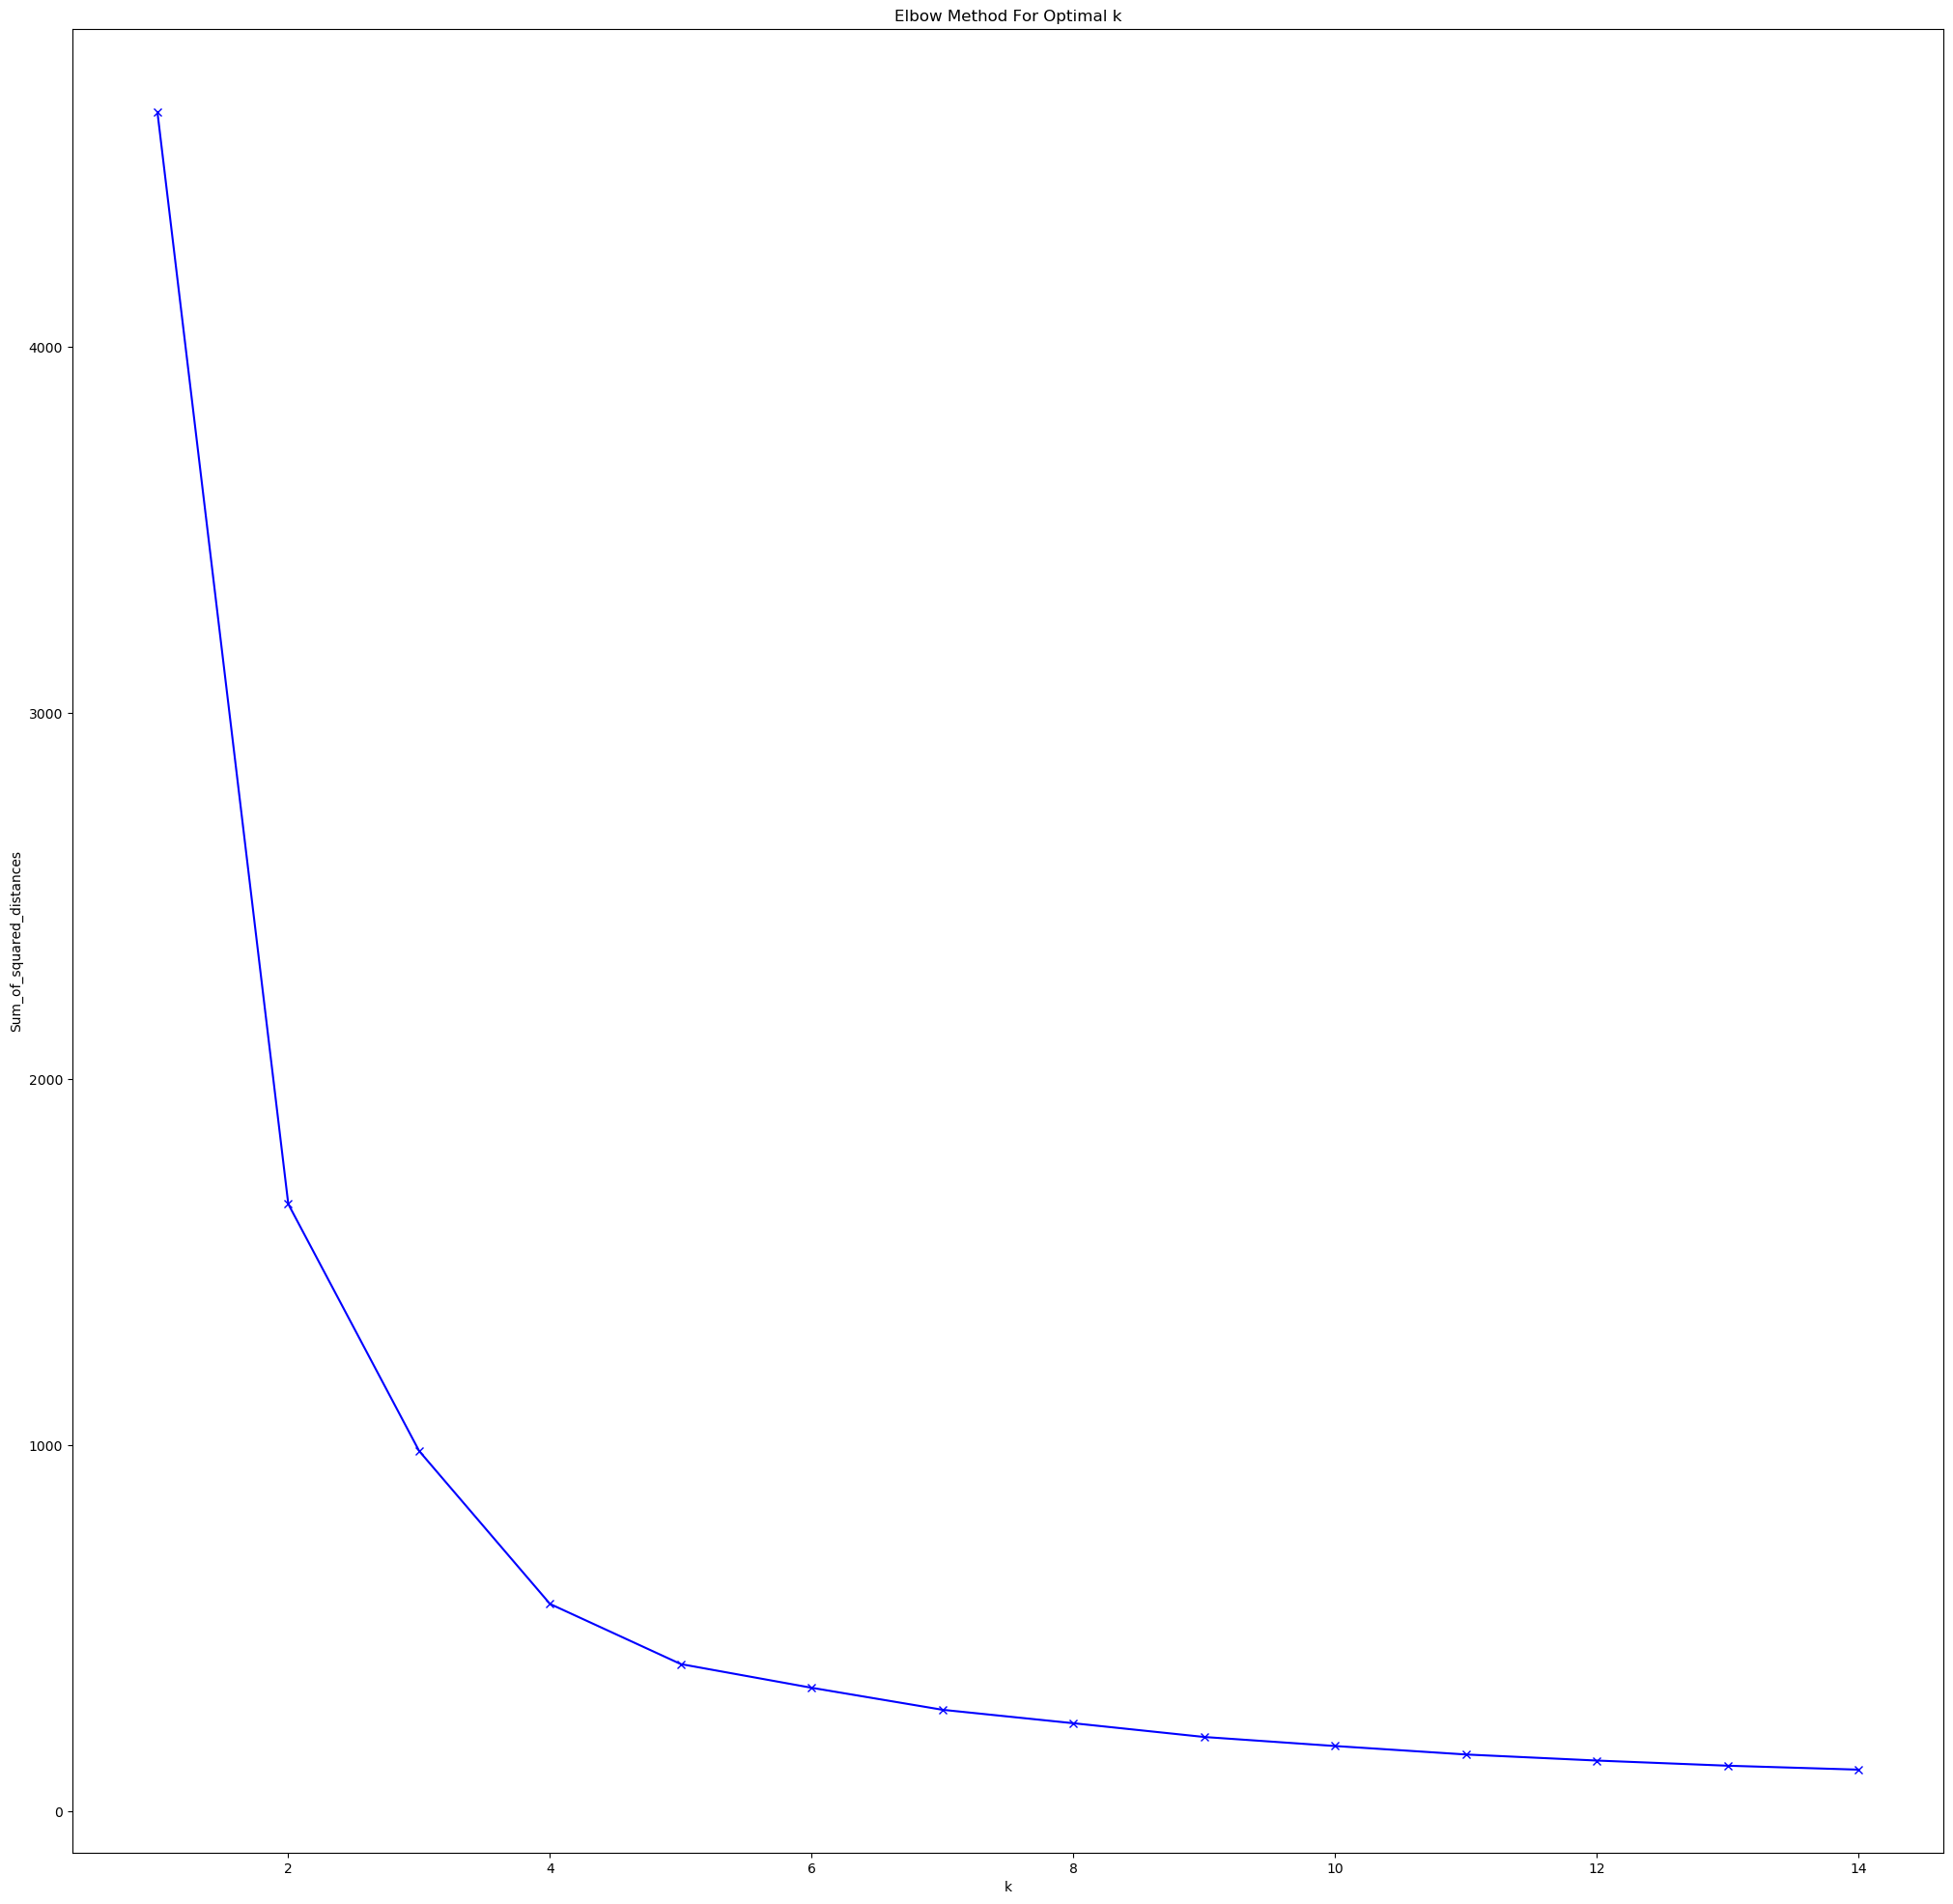

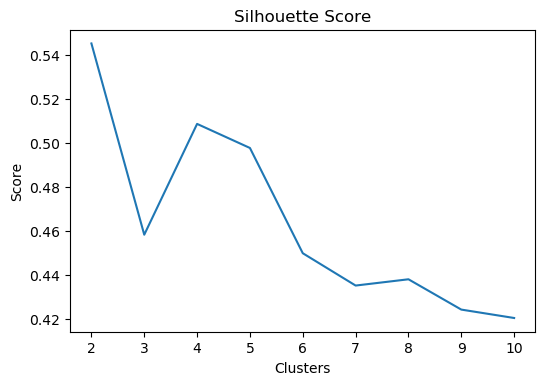

In [9]:
#------------------------DATA PREPARATION--------------------------
data = pd.read_pickle("pisa_un_cia.pkl")
temp = data[["edu", "num people_and_society school_life_expectancy_primary_to_tertiary_education male",
     "num people_and_society school_life_expectancy_primary_to_tertiary_education female",
     "num people_and_society school_life_expectancy_primary_to_tertiary_education total"]]
temp.dropna(axis="rows", how="any", inplace=True)
X = temp.values
KMeans_Cluster_Metrics(X)

In [10]:
#-------------------------CLUSTERING IMPLEMENTATION-----------------------------------
model = KMeans(n_clusters=2)
clusters = model.fit_predict(X)
print ("----MODEL METRICS----\nInertia: {}\nDavies Bouldin: {}\nSilhouette: {}\nCalinski Harabasz: {}\n"
    .format(model.inertia_,davies_bouldin_score(X, clusters), silhouette_score(X, clusters), calinski_harabasz_score(X, clusters)))
temp["labels"] = clusters
data["label"] = temp["labels"]

----MODEL METRICS----
Inertia: 1659.2577875790835
Davies Bouldin: 0.6141889401133697
Silhouette: 0.5452910072358815
Calinski Harabasz: 262.3522507423002



count    66.000000
mean      5.616667
std       2.043947
min       2.400000
25%       4.200000
50%       5.500000
75%       6.600000
max      11.900000
Name: num people_and_society current_health_expenditure, dtype: float64
count    80.000000
mean      7.546250
std       2.589167
min       3.500000
25%       5.700000
50%       7.250000
75%       9.200000
max      17.100000
Name: num people_and_society current_health_expenditure, dtype: float64


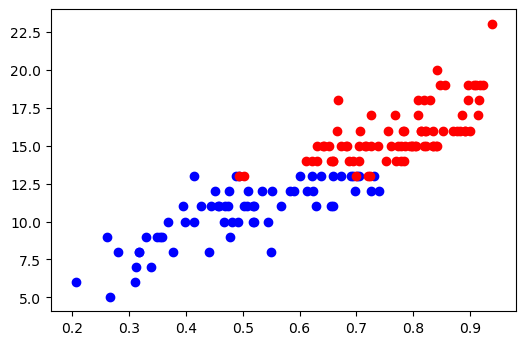

In [11]:
#--------------------------Clustering Visualization---------------------------
temp["country name"] = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")["txt country name"]
data = pd.read_pickle("v1_CIA_World_Factbook_raw_data.pkl")
colors = ["r", "b", "g"]
for lbl in temp["labels"].unique():
  #print(lbl)
  temp2 = temp[temp["labels"] == lbl]
  #print(temp2["country name"].values.tolist())
  #print(temp2.describe().sort_values(by=["mean", "count"], axis=1, ascending=False))
  print(data.loc[temp2.index, "num people_and_society current_health_expenditure"].describe())

  plt.scatter(temp2["edu"], temp2["num people_and_society school_life_expectancy_primary_to_tertiary_education total"], color=colors[lbl])